# Binary Classification

k-Nearest Neighbour is a classifier that can learn the decision boundary between interictal and preictal segments. Spectral power bands extracted from raw EEG signal is used as input and a target label is specified alongside. We use the following convention for target label:

- 0: interictal segment
- 1: preictal segment

In [1]:
import os
import re
import h5py
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
from collections import Counter
from imblearn.under_sampling import NearMiss
import matplotlib.pyplot as plt

In [2]:
data_dir = '/Volumes/My Passport/AI_Research/data/'
patient_names = [name for name in next(os.walk(data_dir))[1]
                 if name != '.ipynb_checkpoints' 
                 if name != 'Patient_1' 
                 if name != 'Patient_2']
patient_names

['Dog_1', 'Dog_2', 'Dog_3', 'Dog_4', 'Dog_5']

## Load data matrix and target vector

In [3]:
for i in range(len(patient_names) - 4):
    patient_name = patient_names[i]
    files_dir = data_dir + patient_name + '/' + 'Power_In_Band_Features' + '/'
    patient_files = os.listdir(files_dir)
    interictal_features = []
    preictal_features = []
    for j in tqdm(range(len(patient_files)), desc=patient_name):
        patient_file_name = patient_files[j]
        h5_path = files_dir + patient_file_name
        if not re.findall('_test_segment_', patient_file_name):
            with h5py.File(h5_path, "r") as f:
                group_key = list(f.keys())[0]
                data = np.array(f.get(group_key))
            if re.findall('_interictal_segment_', patient_file_name):
                interictal_features.append(data.flatten())
            if re.findall('_preictal_segment_', patient_file_name):
                preictal_features.append(data.flatten())    
    interictal_ys = np.zeros((len(interictal_features),))
    preictal_ys = np.ones(len(preictal_features))
    
    interictal_features = np.stack(interictal_features, axis=0)
    preictal_features = np.stack(preictal_features, axis=0)
    
    X = np.vstack((interictal_features, preictal_features))
    y = np.concatenate((interictal_ys, preictal_ys), axis=0)

Dog_1: 100%|██████████| 504/504 [00:00<00:00, 534.31it/s]


In [4]:
print('X:', X.shape)
print('y:', y.shape)

X: (504, 96)
y: (504,)


## Create validation set

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
print(X_train.shape)
print(X_val.shape)

(337, 96)
(167, 96)


In [7]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0.0: 480, 1.0: 24})


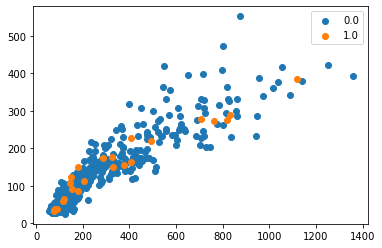

In [8]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

## Undersampling for class imbalance

Counter({0.0: 14, 1.0: 14})


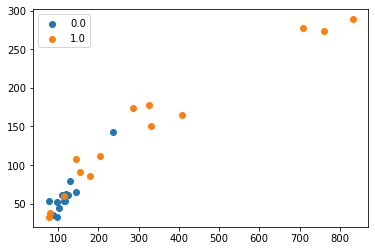

In [10]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=5)
# transform the dataset
X_train, y_train = undersample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
plt.legend()
plt.show()

## Fit model

In [11]:
%%time
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X, y)
y_preds = knn.predict(X_val)

CPU times: user 17.3 ms, sys: 2.51 ms, total: 19.8 ms
Wall time: 17.9 ms


In [12]:
%%time
acc = accuracy_score(y_val, y_preds)
print(f'Accuracy: {acc * 100}')

Accuracy: 96.40718562874252
CPU times: user 1.13 ms, sys: 431 µs, total: 1.56 ms
Wall time: 1.26 ms


## Plot decision boundary

In [ ]:
X_train[:, [0, 2]].shape

In [ ]:
y_train.shape

In [ ]:
plot_decision_regions(X_train[:, [0, 2]], y_train.astype(np.int32), clf=knn, legend=2)

# Adding axes annotations
# plt.xlabel('sepal length [cm]')
# plt.ylabel('petal length [cm]')
plt.title('k-NN on Dog_1')
plt.show()